<a href="https://colab.research.google.com/github/noallynoclan/colab/blob/master/covid_19_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from abc import ABC
from datetime import date, timedelta
from matplotlib import colors
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter
from scipy.optimize import least_squares
plt.style.use('fivethirtyeight')

def bg(df, low=0, high=10000, cmap='Wistia'):
    normed = colors.Normalize(low, high)(df.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

class Sigmoid(ABC):
    def __init__(self, coeffs=[1, 1, 0]):
        self.coeffs = coeffs
        self.bounds = np.array([[0, 1e10], [0, 100], [-100, 100]]).T
        self.initial_values = coeffs
    def __call__(self, x, coeffs=None):
        a, b, c = self.coeffs if coeffs is None else coeffs
        return a / (1 + np.exp(-(b * x + c)))   

def fit(func, y, x=None):
    x = x or np.arange(len(y))
    def residuals(params):
        return func(x, params) - y
    func.coeffs = least_squares(residuals, func.initial_values, '3-point', func.bounds)['x']
    return func

ds = '2020-03-21'
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
url = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{}.xlsx".format(ds)
url

'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-21.xlsx'

In [0]:
data = pd.read_excel(url)
data.head(2)

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,2020-03-21,21,3,2020,2,0,Afghanistan,AF
1,2020-03-20,20,3,2020,0,0,Afghanistan,AF


In [0]:
TH = 1000
df = data[~data['GeoId'].isnull()][['DateRep', 'Cases', 'Deaths', 'GeoId']].copy()
df.columns = ['ds', 'cases', 'deaths', 'country']
df = df.sort_values(['ds', 'country'])
df['cum_cases'] = df.groupby('country')['cases'].cumsum()
df[f'is_{TH}'] = df['cum_cases'] >= TH
df[f'days_since_{TH}'] = df.groupby('country')[f'is_{TH}'].cumsum().astype(int)
df['is_enough_data'] = df['country'].map(df.groupby('country')[f'is_{TH}'].sum() > 5)

mask = (df[f'is_{TH}']) & (df['country'] != 'JPG11668') & ((df['is_enough_data']) | (df['country'] == 'RU'))
pt = df[mask].pivot(f'days_since_{TH}', 'country', 'cum_cases').sort_values(1, axis=1)
display(pt[:30].fillna(0).style.apply(bg).format('{:,.0f}'))

country,US,SE,NO,CH,FR,IT,NL,DE,UK,KR,ES,CN,IR
days_since_1000,,,,,,,,,,,,,
1,"1,025","1,032","1,077","1,121","1,126","1,128","1,135","1,139","1,140","1,146","1,204","1,323","1,501"
2,"1,312","1,121","1,169","1,359","1,412","1,689","1,413","1,296","1,391","1,595","1,639","1,988","2,336"
3,"1,663","1,167","1,308","2,200","1,784","1,835","1,705","1,567","1,543","2,022","2,140","2,775","2,922"
4,"2,174","1,301","1,423","2,200","2,281","2,502","2,051","2,369","1,950","2,931","3,004","4,528","3,513"
5,"2,951","1,423","1,552","2,650","2,876","3,089","2,460","3,062","2,630","3,526","4,231","5,994","4,747"
6,"3,774","1,623","1,742","3,010","3,661","3,858","2,994","3,795","3,277","4,212","5,753","7,734","5,823"
7,"4,661",0,0,"3,888","4,499","4,636",0,"4,838","3,983","4,812","7,753","9,714","6,566"
8,"6,427",0,0,"4,840","5,423","5,883",0,"6,012",0,"5,328","9,191","11,809","7,161"
9,"9,415",0,0,0,"6,633","7,375",0,"7,156",0,"5,766","11,178","14,399","8,042"


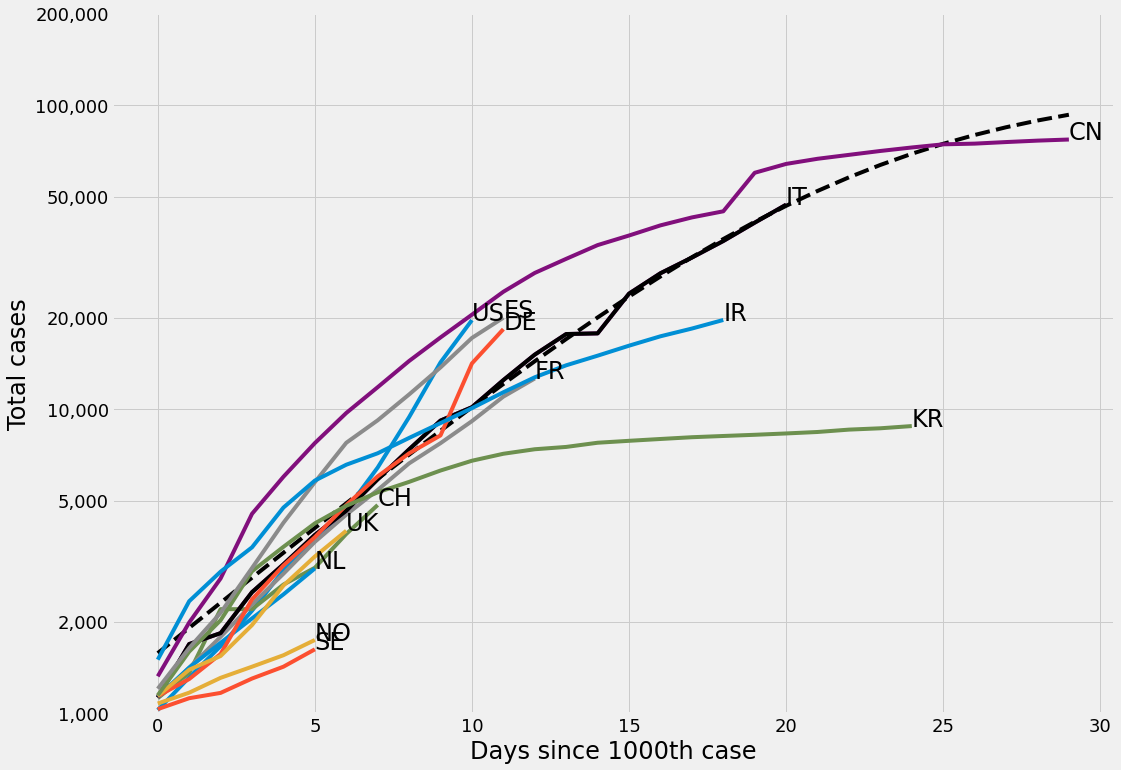

In [0]:
N = 30

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
for country in pt:
    y = pt[country].dropna().values[:N]
    ax.plot(y)
    ax.annotate(country, (np.argmax(y), max(y)), fontsize=24)
    if country in ['IT']:
        x = np.arange(N)
        ax.plot(y, color='k')
        f = fit(Sigmoid(), y)
        ax.plot(x, f(x), ls='--', color='k')
    
ax.set_yscale('log')
ax.set_yticks([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000])
ax.set_ylim(TH, 200000);
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', labelsize=18)
ax.set_ylabel('Total cases', fontsize=24);
ax.set_xlabel(f'Days since {TH}th case', fontsize=24);